# Imports

In [1]:
import pandas as pd
import glob
import os
import numpy as np
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from tqdm.auto import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Functions

In [39]:
def check_missing_players(player_list, player_data):
    missing_players = []
    for game in player_list:
        for team in game:
            for player in team:
                if player.lower() not in player_data:
                    missing_players.append(player)
    return missing_players


def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=None)
        visiting_players = get_names(df, 105, 132)
        home_players = get_names(df, 132, 159)
        home_pitchers = df.iloc[:, 104].tolist()
        visiting_pitchers = df.iloc[:, 102].tolist()
        visiting_players = list_stacker(visiting_pitchers, visiting_players)
        home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df.iloc[:, 9].tolist()
        home_scores = df.iloc[:, 10].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'Batters' not in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0 # might need to flip
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def simulate_betting_season(bets, df, wallet_balance=10000.0):
    wallet_balance_history = []
    for bet in bets:
        bet_amount, bet_team, bet_date = bet
        row = df[(df['date'] == bet_date) & ((df['home_team'] == bet_team) | (df['visiting_team'] == bet_team))]
        if not row.empty and not row.isnull().values.any():
            if row['winner'].values[0]==1:
                winner = row['home_team'].values[0]
                if winner == bet_team:
                    if row['home_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['home_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['home_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            else:
                winner = row['visiting_team'].values[0]
                if winner == bet_team:
                    if row['visiting_open'].values[0] > 0:
                        wallet_balance += bet_amount * (row['visiting_open'].values[0] / 100.0)
                    else:
                        wallet_balance += bet_amount * (100.0 / abs(row['visiting_open'].values[0]))
                else:
                    wallet_balance -= bet_amount
            wallet_balance_history.append((wallet_balance))
        else:
            print(f"No betting data for date: {bet_date}")
    return wallet_balance, wallet_balance_history


def get_player_vector(players, player_data):
    return [player_data[player.lower()] for player in players]


def predict_game_outcome(player_list, player_data, model, augment=False, base_bet=100, scaler=1):
    results, bets, skipped = [], [], []
    for i in range(len(player_list)):
        try:
            visiting_players = player_list.iloc[i][0][0]
            home_players = player_list.iloc[i][0][1]
            visiting_vector = get_player_vector(visiting_players, player_data)
            home_vector = get_player_vector(home_players, player_data)
            game_vector = [item for sublist in visiting_vector + home_vector for item in sublist]  # Flatten the vectors
            game_vector = torch.tensor([game_vector], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results.append(pred)
            bets.append(base_bet * prob * scaler if augment else base_bet)
        except:
            skipped.append(i)
    return results, bets, skipped


def generate_bets(results, bets, df, skipped):
    final_bets = []
    for i, (result, (_, row)) in enumerate(zip(results, df.iterrows())):
        if i in skipped:
            continue
        if result == 1:
            bet_team = row['home_team']
        else:
            bet_team = row['visiting_team']
        bet_date = row['date']
        final_bets.append((bets[i], bet_team, bet_date))
    return final_bets

# Data

In [3]:
player_path = './player_data/'
paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in paths:
    df = pd.read_csv(path)
    view_data(df)

xlsx_path = './betting_odds/'
txt_path = './alldata/gamelogs/'
glfields_path = './alldata/gamelogs/glfields.txt'
paths = [path for path in glob(xlsx_path + '*.xlsx')]
paths_txt = [f'{txt_path}gl20{year}.txt' for year in range(10, 24)]
schedule_paths = [f'./alldata/schedules/{year}schedule.csv' for year in range(2010, 2024)]

# load data
game_path = './game_data/'
player_path = './player_data/'

game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2022' if '2023' if '2021' not in path]
game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if '2021' in path]

player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2021' if '2022' not in path and '2023' not in path]
player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if '2021' in path]

train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

train_player_data = get_player_data(player_csvs_train)
test_player_data = get_player_data(player_csvs_test)

X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset


In [4]:
xlsx_dataframes = []
for i, path in enumerate(paths):
    temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
    temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
    year = path[-9:-5]  # extract year from file name
    if 'Date' in temp_df.columns:
        temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
    xlsx_dataframes.append(temp_df)

try:
    xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
except pd.errors.InvalidIndexError:
    print('Error: Reindexing only valid with uniquely valued Index objects')

with open(glfields_path, 'r') as file:
    glfields_data = file.read()

xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.columns = ['date', 'VH', 'home_team', 'home_open']
visiting_teams_df.columns = ['date', 'VH', 'visiting_team', 'visiting_open']
home_teams_df=home_teams_df[['date','home_team','home_open']]
visiting_teams_df=visiting_teams_df[['date','visiting_team','visiting_open']]
xlsx_dataframes=pd.merge(home_teams_df,visiting_teams_df,on='date')
xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]

headers = [
    "date",
    "number_of_game",
    "day_of_week",
    "visiting_team",
    "visiting_team_league",
    "visiting_team_game_number",
    "home_team",
    "home_team_league",
    "home_team_game_number",
    "visiting_team_score",
    "home_team_score",
    "length_of_game_in_outs",
    "day_night_indicator",
    "completion_information",
    "forfeit_information",
    "protest_information",
    "park_id",
    "attendance",
    "time_of_game_in_minutes",
    "visiting_team_line_scores",
    "home_team_line_scores",
    "visiting_team_at_bats",
    "visiting_team_hits",
    "visiting_team_doubles",
    "visiting_team_triples",
    "visiting_team_homeruns",
    "visiting_team_RBI",
    "visiting_team_sacrifice_hits",
    "visiting_team_sacrifice_flies",
    "visiting_team_hit_by_pitch",
    "visiting_team_walks",
    "visiting_team_intentional_walks",
    "visiting_team_strikeouts",
    "visiting_team_stolen_bases",
    "visiting_team_caught_stealing",
    "visiting_team_grounded_into_double_plays",
    "visiting_team_awarded_first_on_catchers_interference",
    "visiting_team_left_on_base",
    "visiting_team_pitchers_used",
    "visiting_team_individual_earned_runs",
    "visiting_team_team_earned_runs",
    "visiting_team_wild_pitches",
    "visiting_team_balks",
    "visiting_team_putouts",
    "visiting_team_assists",
    "visiting_team_errors",
    "visiting_team_passed_balls",
    "visiting_team_double_plays",
    "visiting_team_triple_plays",
    "home_team_at_bats",
    "home_team_hits",
    "home_team_doubles",
    "home_team_triples",
    "home_team_homeruns",
    "home_team_RBI",
    "home_team_sacrifice_hits",
    "home_team_sacrifice_flies",
    "home_team_hit_by_pitch",
    "home_team_walks",
    "home_team_intentional_walks",
    "home_team_strikeouts",
    "home_team_stolen_bases",
    "home_team_caught_stealing",
    "home_team_grounded_into_double_plays",
    "home_team_awarded_first_on_catchers_interference",
    "home_team_left_on_base",
    "home_team_pitchers_used",
    "home_team_individual_earned_runs",
    "home_team_team_earned_runs",
    "home_team_wild_pitches",
    "home_team_balks",
    "home_team_putouts",
    "home_team_assists",
    "home_team_errors",
    "home_team_passed_balls",
    "home_team_double_plays",
    "home_team_triple_plays",
    "home_plate_umpire_id",
    "home_plate_umpire_name",
    "first_base_umpire_id",
    "first_base_umpire_name",
    "second_base_umpire_id",
    "second_base_umpire_name",
    "third_base_umpire_id",
    "third_base_umpire_name",
    "left_field_umpire_id",
    "left_field_umpire_name",
    "right_field_umpire_id",
    "right_field_umpire_name",
    "visiting_team_manager_id",
    "visiting_team_manager_name",
    "home_team_manager_id",
    "home_team_manager_name",
    "winning_pitcher_id",
    "winning_pitcher_name",
    "losing_pitcher_id",
    "losing_pitcher_name",
    "saving_pitcher_id",
    "saving_pitcher_name",
    "game_winning_rbi_batter_id",
    "game_winning_rbi_batter_name",
    "visiting_starting_pitcher_id",
    "visiting_starting_pitcher_name",
    "home_starting_pitcher_id",
    "home_starting_pitcher_name",
]
for i in range(1, 10):
    headers.extend([
        f"visiting_starting_player_{i}_id",
        f"visiting_starting_player_{i}_name",
        f"visiting_starting_player_{i}_defensive_position"
    ])

for i in range(1, 10):
    headers.extend([
        f"home_starting_player_{i}_id",
        f"home_starting_player_{i}_name",
        f"home_starting_player_{i}_defensive_position"
    ])

headers.extend(["additional_information", "acquisition_information"])

txt_dataframes = []
for path_txt in paths_txt:
    df = pd.read_csv(path_txt, delimiter = ",", quotechar='"', quoting=1, header = None)
    df.columns = headers
    txt_dataframes.append(df)
    # view_data(df)
# txt_dataframes = txt_dataframes.replace({',': '', '\"': ''}, regex=True)
# If you want to view the file in Excel, uncomment the following line
# os.startfile(xlsx_files[0])
# Concatenate all dataframes in txt_dataframes into a single dataframe
txt_dataframes_concat = pd.concat(txt_dataframes)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["home_team_score"] > row["visiting_team_score"] else 2 if row["home_team_score"] == row["visiting_team_score"] else 0, axis=1)

# Drop all columns except for the visiting and home pitchers, starting players, home_team, visiting_team, date, coach, and winner
# txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
#                                               'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
#                                               'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
#                                               'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
#                                               'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
#                                               'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
#                                               'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
#                                               'home_team_score','visiting_team_score','winner']]
txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'winner']]

xlsx_dataframes['date'] = xlsx_dataframes['date'].astype(int)
txt_dataframes_concat['date'] = txt_dataframes_concat['date']
# Now perform the merge operation
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['date', 'home_team', 'visiting_team'])
merged_dataframes_full = pd.merge(txt_dataframes_concat,xlsx_dataframes, on=['date', 'home_team', 'visiting_team'],how="left")

# Now, merged_data should only contain bets on actual games played

player_list_concat = pd.concat(txt_dataframes)
player_list_concat = player_list_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'home_team_score','visiting_team_score',
                                              'home_starting_player_1_defensive_position', 'home_starting_player_2_defensive_position', 
                                              'home_starting_player_3_defensive_position', 'home_starting_player_4_defensive_position', 
                                              'home_starting_player_5_defensive_position', 'home_starting_player_6_defensive_position', 
                                              'home_starting_player_7_defensive_position', 'home_starting_player_8_defensive_position', 
                                              'home_starting_player_9_defensive_position', 'visiting_starting_player_1_defensive_position', 
                                              'visiting_starting_player_2_defensive_position', 'visiting_starting_player_3_defensive_position', 
                                              'visiting_starting_player_4_defensive_position', 'visiting_starting_player_5_defensive_position', 
                                              'visiting_starting_player_6_defensive_position', 'visiting_starting_player_7_defensive_position', 
                                              'visiting_starting_player_8_defensive_position', 'visiting_starting_player_9_defensive_position']]

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['visiting_starting_pitcher_name'],) +
        tuple(row[f'visiting_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'visiting_starting_player_{i}_defensive_position']))
    ),
    (
        (row['home_starting_pitcher_name'],) +
        tuple(row[f'home_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'home_starting_player_{i}_defensive_position']))
    ),
    # row['visiting_team_score'],
    # row['home_team_score']
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['date', 'home_team', 'visiting_team'])

In [5]:
print(merged_player_dataframe['lineup'])

0        [(Roy Halladay, Roy Halladay, Carlos Ruiz, Rya...
1        [(Ubaldo Jimenez, Ubaldo Jimenez, Chris Iannet...
2        [(Shaun Marcum, John Buck, Lyle Overbay, Aaron...
3        [(Felix Hernandez, Rob Johnson, Casey Kotchman...
4        [(Greg Smith, Greg Smith, Chris Iannetta, Todd...
                               ...                        
11200    [(Ashton Goudeau, Ashton Goudeau, Dom Nunez, C...
11201    [(Aaron Civale, Austin Hedges, Yu Chang, Andre...
11202    [(Bruce Zimmermann, Pedro Severino, Ryan Mount...
11203    [(Cole Irvin, Yan Gomes, Seth Brown, Tony Kemp...
11204    [(Chris Sale, Chris Sale, Christian Vazquez, K...
Name: lineup, Length: 11205, dtype: object


# NN

In [8]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)
model

neural_net(
  (gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.15, inplace=False)
  (input_layer): Linear(in_features=440, out_features=880, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=880, out_features=880, bias=True)
  )
  (output_layer): Linear(in_features=880, out_features=2, bias=True)
)

In [9]:
train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [10]:
patience = 5
best_loss = float('inf')
patience_counter = 0
best_model_path = 'best_model.pth'  # File path for saving the best model

for epoch in range(50):  # number of epochs
    model.train()
    train_losses = []
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    print(f'Training Loss: {avg_train_loss}')

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            valid_losses.append(loss.item())

    avg_valid_loss = np.mean(valid_losses)
    print(f'Validation Loss: {avg_valid_loss}')

    # Save the model at each epoch
    epoch_model_path = f'model_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(), epoch_model_path)

    # Update the best model if validation loss improves
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        torch.save(model.state_dict(), best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))

# Evaluate the best model
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Epoch 1:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 1.033853702444248
Validation Loss: 0.7012053114526412


Epoch 2:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6968144071165217
Validation Loss: 0.688846148112241


Epoch 3:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6892649040966438
Validation Loss: 0.7008608947781956


Epoch 4:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.68525213539285
Validation Loss: 0.6816746382152333


Epoch 5:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6822845090633978
Validation Loss: 0.8242382564965416


Epoch 6:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6848160173527147
Validation Loss: 0.675530798294965


Epoch 7:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6807742569812392
Validation Loss: 0.6788323556675631


Epoch 8:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6786158065947275
Validation Loss: 0.6959022318615633


Epoch 9:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6803805894321866
Validation Loss: 0.6786747399498435


Epoch 10:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6797959394555874
Validation Loss: 0.6749596578233382


Epoch 11:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6771694106399697
Validation Loss: 0.7137994766235352


Epoch 12:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6794115323869009
Validation Loss: 0.6746663819341099


Epoch 13:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6760768161879646
Validation Loss: 0.6849343163125655


Epoch 14:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.674619803037593
Validation Loss: 0.6820904980687534


Epoch 15:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6758340691763257
Validation Loss: 0.6735437687705544


Epoch 16:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6744722310828153
Validation Loss: 0.676187706344268


Epoch 17:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6742984188927544
Validation Loss: 0.6797993954490212


Epoch 18:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6713211512754834
Validation Loss: 0.7281791585333207


Epoch 19:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.672950820948081
Validation Loss: 0.6959876961567822


Epoch 20:   0%|          | 0/189 [00:00<?, ?it/s]

Training Loss: 0.6708559182585863
Validation Loss: 0.6776240064817316
Early stopping triggered
Confusion Matrix:
[[462 527]
 [372 791]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       989
           1       0.60      0.68      0.64      1163

    accuracy                           0.58      2152
   macro avg       0.58      0.57      0.57      2152
weighted avg       0.58      0.58      0.58      2152



# Run Season

Number of games:  1051
Predictions:  [1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,

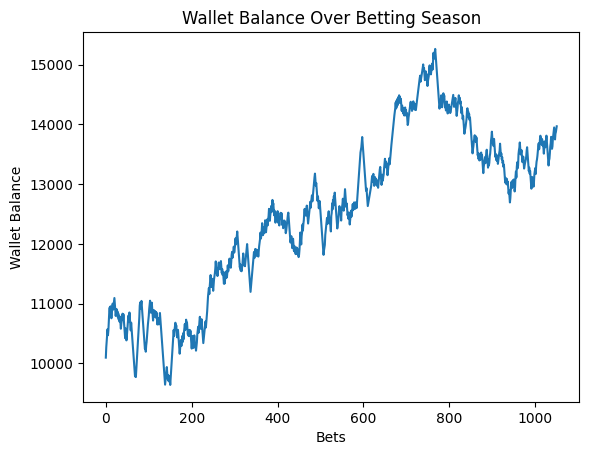

In [43]:
date1, date2 = 20210101, 20220101
subset_df = merged_player_dataframe[(merged_player_dataframe['date'] >= date1) & (merged_player_dataframe['date'] <= date2)]

player_list = subset_df['lineup'].to_frame()

results, bets, skipped = predict_game_outcome(player_list, train_player_data, model, augment=False, scaler=1, base_bet=100)

final_bets = generate_bets(results, bets, subset_df, skipped)

print('Number of games: ', len(subset_df))
print('Predictions: ', results)
print('Bets: ', bets)

wallet_balance, wallet_balance_history = simulate_betting_season(final_bets, merged_dataframes)
print(wallet_balance)
print(wallet_balance_history)
plt.plot(wallet_balance_history)
plt.title('Wallet Balance Over Betting Season')
plt.xlabel('Bets')
plt.ylabel('Wallet Balance')
plt.show()

# Misc

In [33]:
missing_players = check_missing_players(player_list, train_player_data)
print('Missing players:', missing_players)
len(missing_players)

Missing players: ['l', 'i', 'n', 'e', 'u', 'p']


6

In [ ]:
# train_dataset = vector_dataset(X_train_resampled, y_train_resampled)
# instantiate the random undersampler
#rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
#smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
#X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
#print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
#print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))